<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
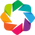

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import os
from som_toolbox import somtoolbox
from som_toolbox.SOMToolBox_Parse import SOMToolBox_Parse
from som_toolbox.somtoolbox import SOMToolbox
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
# Load the dataset
data_path = os.path.join("data")
data = arff.loadarff(os.path.join(data_path, "credit-g.arff"))

# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(data[0])

# Decode byte strings in object columns
for col in df.select_dtypes([object]).columns:
    df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [3]:
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


In [4]:
df.dtypes

checking_status            object
duration                  float64
credit_history             object
purpose                    object
credit_amount             float64
savings_status             object
employment                 object
installment_commitment    float64
personal_status            object
other_parties              object
residence_since           float64
property_magnitude         object
age                       float64
other_payment_plans        object
housing                    object
existing_credits          float64
job                        object
num_dependents            float64
own_telephone              object
foreign_worker             object
class                      object
dtype: object

transform categorical columns to numeric using manual mapping

In [5]:
# First, examine all categorical columns and their unique values
print("=== Categorical Columns and Unique Values ===\n")
categorical_cols = df.select_dtypes([object]).columns.tolist()
for col in categorical_cols:
    unique_vals = sorted(df[col].unique())
    print(f"{col}: {unique_vals}\n")

# Encode categorical variables to numeric with ordinal mappings where applicable
df_encoded = df.copy()

# Define ordinal mappings (preserving meaningful order)
ordinal_mappings = {
    # Checking status: worst (negative) to best
    'checking_status': {
        '<0': 0,              # Negative balance - worst
        '0<=X<200': 1,        # Low positive balance
        '>=200': 2,           # Good balance
        'no checking': 3      # No checking account - can be best or neutral
    },
    
    # Savings status: lowest to highest savings
    'savings_status': {
        'no known savings': 0,    # No savings - worst
        '<100': 1,                # Very low savings
        '100<=X<500': 2,          # Low savings
        '500<=X<1000': 3,         # Moderate savings
        '>=1000': 4               # High savings - best
    },
    
    # Employment: worst (unemployed) to best (long-term employed)
    'employment': {
        'unemployed': 0,          # Unemployed - worst
        '<1': 1,                  # Less than 1 year
        '1<=X<4': 2,              # 1 to 4 years
        '4<=X<7': 3,              # 4 to 7 years
        '>=7': 4                  # 7+ years - best (most stable)
    },
    
    # Property magnitude: value from lowest to highest (note: column name is 'property_magnitude')
    'property_magnitude': {
        'no known property': 0,   # No property - worst
        'car': 1,                 # Car (moderate value)
        'life insurance': 2,      # Life insurance (better)
        'real estate': 3          # Real estate - best (highest value)
    },
    
    # Job quality: worst to best (FIXED: actual value is 'unemp/unskilled non res')
    'job': {
        'unemp/unskilled non res': 0,   # Worst - FIXED
        'unskilled resident': 1,                   # Low skill
        'skilled': 2,                              # Skilled worker
        'high qualif/self emp/mgmt': 3             # Best (management/high qualification)
    },
    
    # Credit history: worst (critical) to best (all paid, no credits) (FIXED: actual value is 'no credits/all paid')
    'credit_history': {
        'critical/other existing credit': 0,       # Critical - worst
        'existing paid': 1,                        # Paid but existing
        'delayed previously': 2,                   # Had delays
        'all paid': 3,                             # All paid
        'no credits/all paid': 4                   # Best - no previous issues (FIXED)
    },
    
    # Personal status: ordered by typical financial stability
    'personal_status': {
        'male single': 0,
        'female div/dep/mar': 1,
        'male div/sep': 2,
        'male mar/wid': 3         # Married/divorced/widowed - might be more stable
    },
    
    # Purpose: ordered by typical credit risk (FIXED: 'domestic appliance' singular, added 'retraining')
    'purpose': {
        'education': 0,
        'furniture/equipment': 1,
        'radio/tv': 2,
        'domestic appliance': 3,      # FIXED: singular form
        'retraining': 4,              # ADDED: retraining
        'repairs': 5,
        'used car': 6,
        'new car': 7,
        'business': 8,
        'other': 9
    },
    
    # Other debtors/guarantors: ordered by level of support (FIXED: 'co applicant' without hyphen)
    'other_parties': {
        'none': 0,                 # No support
        'guarantor': 1,            # Has guarantor (better)
        'co applicant': 2          # Co-applicant (best support) - FIXED: no hyphen
    },
    
    # Housing: ordered by stability/ownership
    'housing': {
        'for free': 0,             # Free housing (unclear stability)
        'rent': 1,                 # Renting
        'own': 2                   # Owning - best (most stable)
    },
    
    # Other payment plans: ordered by risk level
    'other_payment_plans': {
        'none': 0,                 # No other plans
        'stores': 1,               # Store credit
        'bank': 2                  # Bank credit (might be higher commitment)
    },
    
    # Binary variables (yes/no) - FIXED: column name is 'own_telephone', not 'telephone'
    'own_telephone': {'none': 0, 'yes': 1},  # FIXED: column name and values
    'foreign_worker': {'no': 0, 'yes': 1},
    
    # Target variable
    'class': {'bad': 0, 'good': 1}
}

# Apply ordinal mappings to columns that have them defined
print("\n=== Applying Ordinal Mappings ===\n")
for col, mapping in ordinal_mappings.items():
    if col in df_encoded.columns:
        print(f"Mapping {col}: {sorted(mapping.keys())}")
        df_encoded[col] = df_encoded[col].map(mapping)
        # Check for any unmapped values (useful for debugging)
        if df_encoded[col].isna().any():
            unmapped_vals = df[df_encoded[col].isna()][col].unique()
            print(f"  WARNING: Unmapped values in {col}: {unmapped_vals}")

# For any remaining categorical columns (shouldn't be any if mappings are complete)
# Use label encoding as fallback
remaining_categorical = df_encoded.select_dtypes([object]).columns.tolist()
if remaining_categorical:
    print(f"\n=== Using Label Encoding for remaining columns: {remaining_categorical} ===\n")
    label_encoders = {}
    for col in remaining_categorical:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

print("\n=== Encoding Complete ===\n")
print(f"Encoded dataframe shape: {df_encoded.shape}")
print(f"Encoded dataframe dtypes:\n{df_encoded.dtypes.value_counts()}")

=== Categorical Columns and Unique Values ===

checking_status: ['0<=X<200', '<0', '>=200', 'no checking']

credit_history: ['all paid', 'critical/other existing credit', 'delayed previously', 'existing paid', 'no credits/all paid']

purpose: ['business', 'domestic appliance', 'education', 'furniture/equipment', 'new car', 'other', 'radio/tv', 'repairs', 'retraining', 'used car']

savings_status: ['100<=X<500', '500<=X<1000', '<100', '>=1000', 'no known savings']

employment: ['1<=X<4', '4<=X<7', '<1', '>=7', 'unemployed']

personal_status: ['female div/dep/mar', 'male div/sep', 'male mar/wid', 'male single']

other_parties: ['co applicant', 'guarantor', 'none']

property_magnitude: ['car', 'life insurance', 'no known property', 'real estate']

other_payment_plans: ['bank', 'none', 'stores']

housing: ['for free', 'own', 'rent']

job: ['high qualif/self emp/mgmt', 'skilled', 'unemp/unskilled non res', 'unskilled resident']

own_telephone: ['none', 'yes']

foreign_worker: ['no', 'yes']


In [6]:
df_encoded

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,0,6.0,0,2,1169.0,0,4,4.0,0,0,...,3,67.0,0,2,2.0,2,1.0,1,1,1
1,1,48.0,1,2,5951.0,1,2,2.0,1,0,...,3,22.0,0,2,1.0,2,1.0,0,1,0
2,3,12.0,0,0,2096.0,1,3,2.0,0,0,...,3,49.0,0,2,1.0,1,2.0,0,1,1
3,0,42.0,1,1,7882.0,1,3,2.0,0,1,...,2,45.0,0,0,1.0,2,2.0,0,1,1
4,0,24.0,2,7,4870.0,1,2,3.0,0,0,...,0,53.0,0,0,2.0,2,2.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,12.0,1,1,1736.0,1,3,3.0,1,0,...,3,31.0,0,2,1.0,1,1.0,0,1,1
996,0,30.0,1,6,3857.0,1,2,4.0,2,0,...,2,40.0,0,2,1.0,3,1.0,1,1,1
997,3,12.0,1,2,804.0,1,4,4.0,0,0,...,1,38.0,0,2,1.0,2,1.0,0,1,1
998,0,45.0,1,2,1845.0,1,2,4.0,0,0,...,0,23.0,0,0,1.0,2,1.0,1,1,0


In [7]:
# check nas
df_encoded.isna().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

In [8]:
# Convert to numpy array for minisom
data_array = df_encoded.values.astype(float)

# Scale the data to [0, 1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_array)

# Calculate dataset size for SOM dimension recommendation
n_samples = data_scaled.shape[0]
recommended_neurons = int(5 * np.sqrt(n_samples))
print(f"Dataset size: {n_samples} samples")
print(f"Recommended SOM size (5*sqrt(N)): ~{recommended_neurons} neurons")

# SOM Parameters
# Rule of thumb: 5*sqrt(N) neurons, so for ~1000 samples: ~158 neurons
# Options: 10x10=100 (conservative), 12x12=144 (balanced), 15x15=225 (detailed)
SOM_X_AXIS_NODES = 12  # Increased from 8 for better representation
SOM_Y_AXIS_NODES = 12  # Increased from 8 for better representation
SOM_N_VARIABLES = data_scaled.shape[1]

# Learning parameters
ALPHA = 0.7  # Initial learning rate
SIGMA0 = 3.0  # Initial neighborhood radius (30-50% of map size: 12*0.25-0.5 = 3-6)
NEIGHBORHOOD_FUNC = 'gaussian' 
N_ITERATIONS = 10000 

# Create SOM with parameters
som = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES,
              sigma=SIGMA0,
              learning_rate=ALPHA,
              neighborhood_function=NEIGHBORHOOD_FUNC,
              random_seed=42)

# Initialize weights using PCA
som.pca_weights_init(data_scaled)

# Train the SOM
som.train_random(data_scaled, N_ITERATIONS, verbose=True)

print(f"\nSOM Training Complete!")
print(f"Quantization error: {som.quantization_error(data_scaled):.4f}")
print(f"Topographic error: {som.topographic_error(data_scaled):.4f}")  

# Reshape weights from (m, n, dimension) to (m*n, dimension) for SOMToolbox
weights_3d = som.get_weights()  # Shape: (m, n, dimension)
weights_2d = weights_3d.reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)  # Shape: (m*n, dimension)

# Convert classes to numpy array
classes_array = df_encoded['class'].values if 'class' in df_encoded.columns else None

# Convert component_names to list (not numpy array) to avoid boolean evaluation issues
component_names_list = df_encoded.columns.tolist()

sm = SOMToolbox(weights=weights_2d, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
            dimension=SOM_N_VARIABLES, input_data=data_scaled,
            classes=classes_array, component_names=component_names_list)
sm._mainview

Dataset size: 1000 samples
Recommended SOM size (5*sqrt(N)): ~158 neurons


/Users/florianmende/Documents/TU_Lokal/SOS/sos_tuwien/.venv/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9723502067101895

SOM Training Complete!
Quantization error: 0.9724
Topographic error: 0.0630


BokehModel(combine_events=True, render_bundle={'docs_json': {'2e428ec2-2ae2-4a28-a49f-0d9db203a7ae': {'version…

## 1 Identify border effects and magnification factors

Visualization to use: Compare the U-Matrix with the Frequency (Hit) Map.
U-Matrix:
Looking at the U-Matrix, there is evidence of border effects, particularly on the left edge (around y=0).
Observation: There is a distinct high-distance cluster (green/red spikes) right at (-0.5, 0).
This suggests the map is stretching significantly at the boundary to accommodate outlier data points that lie far outside the main distribution. The "walls" (high U-matrix values) seem to press against the edges of the map rather than being fully contained within it.

Magnification Factors:

Comparing the U-Matrix and the Hit Histogram (Top Right):
Spots at (-0.5, -0.5) and (0.5, -0.5) are very bright, indicating high hit counts -> high magnification in those areas
U matrix shows low values there -> 


U-Matrix with pie overlay-> 
not that well separated, but we see most of the positive class datapoints in bottom left with high distances
and some of them on middle left and some on top -> ie not really together
only bottom left majority of positive class, other areas quite mixed

QE not evenly distributed, concentrated at bottom left and middle left
-> overlaps with hit histogram -> potential sign of underfitting -> potentially more neurons needed or learning rate decay too fast


# Different random seed

In [ ]:
# Create SOM with parameters
som2 = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES,
              sigma=SIGMA0,
              learning_rate=ALPHA,
              neighborhood_function=NEIGHBORHOOD_FUNC,
              random_seed=123)

# Initialize weights using PCA
som2.pca_weights_init(data_scaled)

# Train the SOM
som2.train_random(data_scaled, N_ITERATIONS, verbose=True)

print(f"\nSOM Training Complete!")
print(f"Quantization error: {som2.quantization_error(data_scaled):.4f}")
print(f"Topographic error: {som2.topographic_error(data_scaled):.4f}")  

# Reshape weights from (m, n, dimension) to (m*n, dimension) for SOMToolbox
weights_3d = som2.get_weights()  # Shape: (m, n, dimension)
weights_2d = weights_3d.reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)  # Shape: (m*n, dimension)

# Convert classes to numpy array
classes_array = df_encoded['class'].values if 'class' in df_encoded.columns else None

# Convert component_names to list (not numpy array) to avoid boolean evaluation issues
component_names_list = df_encoded.columns.tolist()

sm = SOMToolbox(weights=weights_2d, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
            dimension=SOM_N_VARIABLES, input_data=data_scaled,
            classes=classes_array, component_names=component_names_list)
sm._mainview

/Users/florianmende/Documents/TU_Lokal/SOS/sos_tuwien/.venv/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9746838270929756

SOM Training Complete!
Quantization error: 0.9747
Topographic error: 0.0720


BokehModel(combine_events=True, render_bundle={'docs_json': {'1ce88014-de5c-4e9e-b365-5dca552ecdcf': {'version…

## 3) Analyze different map sizes:
- Train 2 additional SOMs varying the size (very small / very large) (provide reasons for choice
of sizes)
- Train each map with rather large neighborhood radius and high learning rate (provide reasons
for the definition of „high“!)
- Analyse in detail the a) class distribution, b) cluster structure, c) quantization errors, d)
topology violations. Also, e) analyze how clusters shift, change in relative size, and how their
relative position to each other changes or remains the same. f) Check for aspects such as
magnification factors. What is the resulting granularity of clusters visible on the small and large
maps? Are the same clusters visible in the very large map as in the regular map?
- Describe and compare the structures found (providing detailed info on visualizations and
parameters)

In [ ]:
# SOM Parameters
# As a rule of thumb: 5*sqrt(N) neurons, so for ~1000 samples ≈158 neurons.
# Larger maps help mitigate underfitting and allow more spatial expression.
# we use a large map (32x32=1024 neurons) to allow greater detail and separation.

SOM_X_AXIS_NODES = 32
SOM_Y_AXIS_NODES = 32
SOM_N_VARIABLES = data_scaled.shape[1]

# Learning parameters
# "High" learning rate: Typically, values in the range [0.3, 0.7] are considered high, as the SOM literature often recommends initial values of 0.1-0.5 for conservative training; 
# values closer to 1 result in rapid, drastic updates, but risk instability. Using ALPHA=0.7 is considered high and helps the SOM quickly adapt global structure early in training.
ALPHA = 0.7

# Neighborhood radius: Initial values of 50-100% of the map's longest edge are considered large.
# For a 32x32 grid, max(map axis) = 32 → 60% * 32 ≈ 19.2. Starting with a large radius enables broad, coarse topological ordering.
SIGMA0 = 19.0

NEIGHBORHOOD_FUNC = 'gaussian'
N_ITERATIONS = 10000

# Create SOM with parameters
som_large = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES,
              sigma=SIGMA0,
              learning_rate=ALPHA,
              neighborhood_function=NEIGHBORHOOD_FUNC,
              random_seed=123)

# Initialize weights using PCA
som_large.pca_weights_init(data_scaled)

# Train the SOM
som_large.train_random(data_scaled, N_ITERATIONS, verbose=True)

print(f"\nSOM Training Complete!")
print(f"Quantization error: {som_large.quantization_error(data_scaled):.4f}")
print(f"Topographic error: {som_large.topographic_error(data_scaled):.4f}")  

# Reshape weights from (m, n, dimension) to (m*n, dimension) for SOMToolbox
weights_3d = som_large.get_weights()  # Shape: (m, n, dimension)
weights_2d = weights_3d.reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)  # Shape: (m*n, dimension)

# Convert classes to numpy array
classes_array = df_encoded['class'].values if 'class' in df_encoded.columns else None

# Convert component_names to list (not numpy array) to avoid boolean evaluation issues
component_names_list = df_encoded.columns.tolist()

sm = SOMToolbox(weights=weights_2d, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
            dimension=SOM_N_VARIABLES, input_data=data_scaled,
            classes=classes_array, component_names=component_names_list)
sm._mainview

/Users/florianmende/Documents/TU_Lokal/SOS/sos_tuwien/.venv/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.1277244050547792

SOM Training Complete!
Quantization error: 1.1277
Topographic error: 0.0120


BokehModel(combine_events=True, render_bundle={'docs_json': {'9829fcf4-8546-4df9-9476-b7d3c200840e': {'version…

In [13]:
# SOM Parameters
# As a rule of thumb: 5*sqrt(N) neurons, so for ~1000 samples ≈158 neurons.
# Larger maps help mitigate underfitting and allow more spatial expression.
# we use a large map (32x32=1024 neurons) to allow greater detail and separation.

SOM_X_AXIS_NODES = 5
SOM_Y_AXIS_NODES = 5
SOM_N_VARIABLES = data_scaled.shape[1]

# Learning parameters
# "High" learning rate: Typically, values in the range [0.3, 0.7] are considered high, as the SOM literature often recommends initial values of 0.1-0.5 for conservative training; 
# values closer to 1 result in rapid, drastic updates, but risk instability. Using ALPHA=0.7 is considered high and helps the SOM quickly adapt global structure early in training.
ALPHA = 0.7

# Neighborhood radius: Initial values of 50-100% of the map's longest edge are considered large.
# For a 32x32 grid, max(map axis) = 32 → 60% * 32 ≈ 19.2. Starting with a large radius enables broad, coarse topological ordering.
SIGMA0 = 4

NEIGHBORHOOD_FUNC = 'gaussian'
N_ITERATIONS = 10000

# Create SOM with parameters
som_small = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES,
              sigma=SIGMA0,
              learning_rate=ALPHA,
              neighborhood_function=NEIGHBORHOOD_FUNC,
              random_seed=123)

# Initialize weights using PCA
som_small.pca_weights_init(data_scaled)

# Train the SOM
som_small.train_random(data_scaled, N_ITERATIONS, verbose=True)

print(f"\nSOM Training Complete!")
print(f"Quantization error: {som_small.quantization_error(data_scaled):.4f}")
print(f"Topographic error: {som_small.topographic_error(data_scaled):.4f}")  

# Reshape weights from (m, n, dimension) to (m*n, dimension) for SOMToolbox
weights_3d = som_small.get_weights()  # Shape: (m, n, dimension)
weights_2d = weights_3d.reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)  # Shape: (m*n, dimension)

# Convert classes to numpy array
classes_array = df_encoded['class'].values if 'class' in df_encoded.columns else None

# Convert component_names to list (not numpy array) to avoid boolean evaluation issues
component_names_list = df_encoded.columns.tolist()

sm = SOMToolbox(weights=weights_2d, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
            dimension=SOM_N_VARIABLES, input_data=data_scaled,
            classes=classes_array, component_names=component_names_list)
sm._mainview

/Users/florianmende/Documents/TU_Lokal/SOS/sos_tuwien/.venv/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.2405818035615421

SOM Training Complete!
Quantization error: 1.2406
Topographic error: 0.0540


BokehModel(combine_events=True, render_bundle={'docs_json': {'d657c38b-27fd-4efc-87c8-137442a156c8': {'version…

## 4) Analyze different initial neighborhood radius settings:
- Train the very large SOM as specified above, but with a much too small neighborhood radius.
- Analyse the a) cluster structure, b) quantization errors, c) topology violations. d) In how far
does this map differ from the very large map trained with a correct/high initial neighborhood
radius?
- Describe and compare the structures found (what is the effect of a „too small“
neighborhood radius? How to detect it?)

## 5) Analyze different initial learning rates:
- Train the regular-sized SOM as specified above, but with a (I) much too large / (II) much too
small learning rate (provide justification for the setting of the parameter)
- Analyse for both (I) and (II) a) cluster structure, b) quantization errors, c) topology violations.
d) In how far do these two maps differ from the well-trained map analyzed above?
- Describe and compare the structures found (how can you detect „too small“ learning
rates? When do they start to make sense?

## 6) Analyze different max iterations:
- Train a regular SOM using 2, 5, 10, 50, 100, 1000, 5000, 10000 iterations
- Analyse cluster structure. a) When do cluster structures start to emerge? b) After how many
iterations do they stabilize? c) How can you tell from the quality measures whether the map is
stable? d) Which visualizations help you discover not-yet stable SOM mappings?
- Describe and compare the structures found (what is the effect of a „too low“ number of
iterations, when does it start to converge properly/lead to reasonable structures?)

## 7) Detailed analysis of an „Optimal SOM“:

- Train a SOM using what you consider to be „optimal parameters“ based on sub-tasks 1-6.
- Describe the final model following MLSO.
- Provide a detailed interpretation of the cluster/class structures using a combination of
visualizations and their parameter settings. Describe the findings in detail, specifically
analyzing and providing rationale for:

Cluster densities / cardinalities, shapes: what can you tell about the cluster sizes
shapes, their cardinalities and densities? Can you observe areas of higher/lower
densities? Compare different visualizations that support (or contradict) your hypothesis
and reason/explain why they do so.

Hierarchical cluster relationships: can you detect any hierarchies in the data? How do
they seem to be structured? Which clusters are similar, which are very distant, how
could they be related? Compare different visualizations that support (or contradict)
your hypothesis and reason/explain why they do so.
Topological relations / violations: in which areas can you observe topology violations?

What types of violations do you observe in which areas of the map (i.e. actual violations
due to bad training or the inherent structure of the data vs. cluster data that is mapped
onto the plane). In how far do different visualizations agree on these violations?
Compare different visualizations that support (or contradict) your hypothesis and
reason/explain why they do so.

Class distribution: Which classes are mapped onto which parts of the map? How do
they relate to each other? In how far does the class distribution match the cluster
structure? Which classes are well-separated, which ones less so? What might be the
reason for these overlaps? Is the mapping less correct in these regions (e.g. higher
error measures)? Are these areas well-separated. Which classes form homogeneous
clusters, which form sub-clusters, how similar are these sub-clusters?

Quality of the map in terms of vector quantization and topology violation: is the quality
homogeneous, are there certain areas or classes where the quality of the mapping is
lower, others where it is higher?